In [49]:
import re

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

print(pd.__version__)

0.24.2


In [67]:
# Helper functions
def style_diff(df, df_orig):
        style = {True: '', 
                 False: 'color: red; background-color: yellow'}
        df_style = (df == df_orig).replace(style)
        return df.style.apply(lambda x: df_style, axis=None)

def random_subset_diff(df, df_orig, n=200):
    if df.shape[0] < n:
        n = df.shape[0]
    return style_diff(df.sample(n), df_orig.sample(n))

def nan_rows(df):
    if isinstance(df, pd.Series):
         return df[df.isna()]
    else:
        return df[df.isna().any(axis=1)]
    
def print_df(df, desc, rows=5):
    print(f'DataFrame of {desc} with shape {df.shape}:', 
          df.head(rows), sep='\n', end='\n'*2)

In [51]:
# Create DataFrames
category_r = pd.read_csv('./data/food_category.csv',
                       dtype={'id': float, 'code': str, 'description': str})

food_r = pd.read_csv('./data/food.csv',
                       dtype={'fdc_id': int,'data_type': str, 
                              'description': str,
                              'food_category_id': float, 
                              'publication_date': object})

nutrient_r = pd.read_csv('./data/nutrient.csv',
                       dtype={'id': int,'name': str, 
                              'unit_name': str,
                              'nutrient_nbr': float, 
                              'rank': float})

portion_r = pd.read_csv('./data/food_portion.csv',
                       dtype={'id': int,'fdc_id': int,'seq_num': float,
                              'amount': float, 'measure_unit_id': int,
                              'portion_description': str,'modifier': str,
                              'gram_weight': float, 'data_points': float,
                              'footnote': str, 'min_year_acquired': float})

measure_r = pd.read_csv('./data/measure_unit.csv',
                       dtype={'id': int, 'name': str})

food_nutrient_r = pd.read_csv('./data/food_nutrient.csv',
                              dtype={'id': int, 'fdc_id': int,
                                     'nutrient_id': int, 'amount': float})

dfs = {'category': category_r, 'food': food_r, 'food_nutrient': food_nutrient_r,
       'nutrient': nutrient_r, 'portion': portion_r, 'measure': measure_r}


In [52]:
for name, df in dfs.items():
    print(f'--- Nans in DataFrame: {name} ---')
    print(df[df.isna().any(axis=1)])
    print(f'{name}:')
    print(df.head(5))

--- Nans in DataFrame: category ---
Empty DataFrame
Columns: [id, code, description]
Index: []
category:
    id  code             description
0  1.0  0100  Dairy and Egg Products
1  2.0  0200        Spices and Herbs
2  3.0  0300              Baby Foods
3  4.0  0400           Fats and Oils
4  5.0  0500        Poultry Products
--- Nans in DataFrame: food ---
Empty DataFrame
Columns: [fdc_id, data_type, description, food_category_id, publication_date]
Index: []
food:
   fdc_id       data_type                                        description  \
0  167512  sr_legacy_food  Pillsbury Golden Layer Buttermilk Biscuits, Ar...   
1  167513  sr_legacy_food  Pillsbury, Cinnamon Rolls with Icing, refriger...   
2  167514  sr_legacy_food  Kraft Foods, Shake N Bake Original Recipe, Coa...   
3  167515  sr_legacy_food     George Weston Bakeries, Thomas English Muffins   
4  167516  sr_legacy_food         Waffles, buttermilk, frozen, ready-to-heat   

   food_category_id publication_date  
0          

DataFrame of nutrient with shape (474, 3):
     id                              nutrient unit_name
0  2047      Energy (Atwater General Factors)      KCAL
1  2048     Energy (Atwater Specific Factors)      KCAL
2  1001                                Solids         G
3  1002                              Nitrogen         G
4  1003                               Protein         G
5  1004                     Total lipid (fat)         G
6  1005           Carbohydrate, by difference         G
7  1006  Fiber, crude (DO NOT USE - Archived)         G
8  1007                                   Ash         G
9  1008                                Energy      KCAL

DataFrame of category with shape (28, 2):
    id                category
0  1.0  Dairy and Egg Products
1  2.0        Spices and Herbs
2  3.0              Baby Foods
3  4.0           Fats and Oils
4  5.0        Poultry Products

Chosen food categories:
['Fats and Oils', 'Fruits and Fruit Juices', 'Vegetables and Vegetable Products', 'Nut 

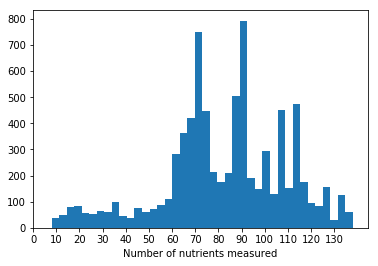

In [72]:

nutrient = nutrient_r.loc[:, 'id':'unit_name']
nutrient = nutrient.rename(columns={'name': 'nutrient'})
nutrient.loc[nutrient['id']==1062, 'nutrient'] = 'Energy (kJ)'
print_df(nutrient, 'nutrient', rows=10)
  
category = category_r.drop('code', axis=1).rename(columns={'description': 'category'})
print_df(category, 'category')

# print('All food categories:', category['description'].values, sep='\n')

vegan_cat = [
    'Fats and Oils', 'Fruits and Fruit Juices',
    'Vegetables and Vegetable Products', 'Nut and Seed Products',
    'Legumes and Legume Products', 'Cereal Grains and Pasta',
]
print('Chosen food categories:', vegan_cat, sep='\n', end='\n'*2)

# Ignore food with missing category for now. Maybe use classification
# to label the missing data.
food = food_r.drop(['data_type', 'publication_date'], axis=1)
food = food.dropna(subset=['description'], axis=0)
food.rename(columns={'description': 'food'}, inplace=True)
print_df(food, 'food')

# The nutrient amount is for a 100 g portion
food_nutrient = food_nutrient_r.loc[:, 'fdc_id':'amount']
food_nutrient = food_nutrient.rename(columns={'amount': 'nutrient_amount'})
print_df(food_nutrient, 'food_nutrient')


portion = portion_r[['seq_num', 'fdc_id', 'amount',
                    'modifier', 'gram_weight']]
portion = portion.rename(columns={'amount': 'portion',
                                  'gram_weight': 'portion_grams'})
# Take only the first type of portion if there are more than one
portion = portion[portion['seq_num'] == 1]
portion.drop('seq_num', axis=1, inplace=True)

# How may nutrients where measured for each food
ids, counts = np.unique(food_nutrient['fdc_id'].values, return_counts=True)

plt.hist(counts, bins='auto')
plt.xlabel('Number of nutrients measured')
plt.xticks(np.arange(0,max(counts), 10))
plt.show()


In [70]:

missing_cat = food['food_category_id'].isna()

df = pd.merge(food, category, left_on='food_category_id', 
              right_on='id')
df.drop(['id', 'food_category_id'], inplace=True, axis=1)
print_df(df, 'food merged with category')

vegan_food = df[df['category'].isin(vegan_cat)]
print_df(vegan_food, 'food filtered based on vegan food categories')

vegan_food_missing = vegan_food.merge(portion, on='fdc_id', how='left')

vegan_food = vegan_food.merge(portion, on='fdc_id')
print_df(vegan_food, 'vegan food with portion size')

print_df(nan_rows(vegan_food_missing), 'Foods with missing portion sizes')
nan_rows(vegan_food_missing).to_csv('missing_portions.csv')

# Store the number of vegan foods
num_foods = vegan_food.shape[0]

# This is a one-to-many join
vegan_food = vegan_food.merge(food_nutrient, on='fdc_id', validate='1:m')
print_df(vegan_food, 'vegan food portion with nutrient ids')

# A many-to-one join
vegan_food = vegan_food.merge(nutrient, left_on='nutrient_id',
                              right_on='id', validate='m:1')
vegan_food = vegan_food.drop(['id', 'nutrient_id'], axis=1)
print_df(vegan_food, 'vegan food portion with nutrient amounts')


DataFrame of food merged with category with shape (7793, 3):
   fdc_id                                               food        category
0  167512  Pillsbury Golden Layer Buttermilk Biscuits, Ar...  Baked Products
1  167513  Pillsbury, Cinnamon Rolls with Icing, refriger...  Baked Products
2  167514  Kraft Foods, Shake N Bake Original Recipe, Coa...  Baked Products
3  167515     George Weston Bakeries, Thomas English Muffins  Baked Products
4  167516         Waffles, buttermilk, frozen, ready-to-heat  Baked Products

DataFrame of food filtered based on vegan food categories with shape (1993, 3):
      fdc_id                                               food  \
1051  167602    Seaweed, Canadian Cultivated EMI-TSUNOMATA, dry   
1052  167603  Seaweed, Canadian Cultivated EMI-TSUNOMATA, re...   
1053  167604     Potatoes, hash brown, refrigerated, unprepared   
1054  167605  Potatoes, hash brown, refrigerated, prepared, ...   
1055  167606  Sweet Potatoes, french fried, frozen as packag.

In [ ]:
# Number of measurement for each nutrient
# vegan_food.groupby('nutrient').apply(lambda df: print(df.shape[0], df['nutrient'].iloc[0]))
# Energy has two measurements per food: kJ and kCal

all_nutrients = sorted(set(vegan_food['nutrient'].values))
# print(all_nutrients)

# weight in kg
weight = 70.0
# kcal per day
kcal = 2800.0
#WHO recommends saturated fat to be 10% of energy intake. So, 
#0.1 * 2800 = 280 kcal -> 280 / 9 ~ 31 g
s_fat = 0.1 * kcal / 9
#FAO recommends 8 mg Histidine / kg body weight. So, 70 kg * 12 / 1000 =
#0.84 g Histidine
hist = weight * 12 / 1000
# Iron: 0.8 - 1.0 mg iron/day is lost. 9 mg / day is recommended 
# Protein: EFSA set 0.83 g protein / kg body weight: 70 * 0.8 = 56 g
protein = 0.83 * weight
# WHO recommendations for essential AAs in mg / kg body weight
# https://iris.who.int/handle/10665/43411
aa = {
    'Leu': 39,
    'Lys': 30,
    'Ile': 20,
    'Val': 26,
    'Thr': 15,
    'Phe': 25,
    'Trp': 4,
    'Met': 15,
    'His': 10
}
conv_fac = weight / 1000
# Calculate the total amounts of needed amino acids
aa_t = {a: mg * conv_fac for a, mg in aa.items()}
'''Positive values indicate daily reference value; Negative values
indicate daily maximum intake; None indicates no recommended amount 
from literature. 
'''
target_nutrients = {
    'Calcium, Ca': 750, 'Carbohydrate, by difference': None, 
    'Carotene, beta': None, 'Cholesterol': -300, 'Choline, total': 400, 
    'Energy': -kcal, 'Fatty acids, total monounsaturated': None, 
    'Fatty acids, total polyunsaturated': None, 'Fatty acids, total saturated': -s_fat,
    'Fiber, total dietary': 25, 'Folate, total': 350, 
    'Histidine': aa_t['His'], 'Iron, Fe': 9, 'Isoleucine': aa_t['Ile'], 'Leucine': aa_t['Leu'], 'Lysine': aa_t['Lys'],
    'Magnesium, Mg': 350, 'Methionine': aa_t['Met'], 'Niacin': None, 'PUFA 18:2': None, 'PUFA 18:3': None, 
    'PUFA 18:4': None, 'Pantothenic acid': None, 'Phenylalanine': aa_t['Phe'], 'Phosphorus, P': None, 
    'Potassium, K': None, 'Protein': None, 'Retinol': None, 'Riboflavin': None, 'Selenium, Se': None, 
    'Sodium, Na': None, 'Thiamin': None, 'Threonine': aa_t['Thr'],'Tocopherol, gamma': None, 
    'Total lipid (fat)': None, 'Tryptophan': aa_t['Trp'], 'Valine': aa_t['Val'], 'Vitamin A, RAE': None, 
    'Vitamin B-6': None, 'Vitamin C, total ascorbic acid': None, 
    'Vitamin K (phylloquinone)': None, 'Zinc, Zn': None
}
# Units for each target nutrient
for name in target_nutrients.keys():
    unit = nutrient.loc[nutrient['nutrient'] == name, 'unit_name'].values
    print(f'{name} uses units of {unit}')

vegan_food = vegan_food.loc[vegan_food['nutrient'].isin(target_nutrients), :]
print_df(vegan_food, 'Vegan foods with selected nutrients')

Calcium, Ca uses units of ['MG']
Carbohydrate, by difference uses units of ['G']
Carotene, beta uses units of ['UG']
Cholesterol uses units of ['MG']
Choline, total uses units of ['MG']
Energy uses units of ['KCAL']
Fatty acids, total monounsaturated uses units of ['G']
Fatty acids, total polyunsaturated uses units of ['G']
Fatty acids, total saturated uses units of ['G']
Fiber, total dietary uses units of ['G']
Folate, total uses units of ['UG']
Histidine uses units of ['G']
Iron, Fe uses units of ['MG']
Isoleucine uses units of ['G']
Leucine uses units of ['G']
Lysine uses units of ['G']
Magnesium, Mg uses units of ['MG']
Methionine uses units of ['G']
Niacin uses units of ['MG']
PUFA 18:2 uses units of ['G']
PUFA 18:3 uses units of ['G']
PUFA 18:4 uses units of ['G']
Pantothenic acid uses units of ['MG']
Phenylalanine uses units of ['G']
Phosphorus, P uses units of ['MG']
Potassium, K uses units of ['MG']
Protein uses units of ['G']
Retinol uses units of ['UG']
Riboflavin uses units

In [56]:
# Foods/preparations to be filtered out (exception for Nuts and Seeds)
stop_words = [
    'isolate', 'dehydrated', 'dried', 'concentrate', 'enrich', 'dry',
    'fried', 'added', 'uncooked', 'meat', 'fish', 'beef', 'pork', 
    'chicken', 'fortified', 'crude', 'lard', 'bran', 'butter', 'fat',
    'salad dressing', 'mayo', 'vegetarian', 'egg', 'fresh-refrigerated'
]
cottonseed = vegan_food['food'].str.lower().str.contains('cottonseed', regex=False)
pattern = re.compile('|'.join(stop_words), flags=re.IGNORECASE)
stopped = vegan_food['food'].str.contains(pattern) 
nuts_seeds = vegan_food['category'] == 'Nut and Seed Products'

vegan_food = vegan_food[(~stopped) | (nuts_seeds & ~cottonseed)]

# What is the distribution of the nutrients values
nutrient_groups = vegan_food.groupby('nutrient')
nutrient_groups['nutrient_amount'].describe()

# get the top five foods for each nutrient in each category to csv
idx = vegan_food.groupby(['category', 'nutrient'])['nutrient_amount'].nlargest(5).index.get_level_values(2)
temp = vegan_food.loc[idx, ['category', 'nutrient', 
                            'food', 'nutrient_amount', 'unit_name']]
temp.to_csv('top.csv', index=False)
